# 1.6 Homework

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.



In [1]:
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Q1. Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".



In [2]:
#Download the data for January and February 2021.
#Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')

#Read the data for January. How many records are there?
print('There are',len(df),'records')


There are 1154112 records


## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.


In [3]:
#Convert duration type tp datetime
df['duration'] = df.dropOff_datetime - df.pickup_datetime

#Convert duration datetime to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [4]:
#What's the average trip duration in January?
print('The average trip duration(min) is', round(df.duration.mean(),3),'minutes')

The average trip duration(min) is 19.167 minutes


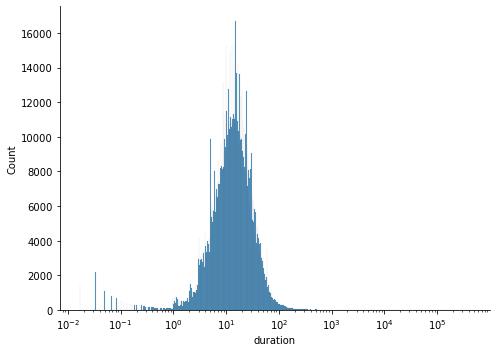

In [5]:
#Data preparation
#Check the distribution of the duration variable. There are some outliers.


sns.displot(data=df,
  x="duration",
  kind="hist",
  aspect=1.4,
  log_scale=10)

In [6]:
df.duration.describe(percentiles= [0.99])
print('')
print('Most of the trips last between',df.quantile(0.02).min(),'&',df.duration.quantile(0.98).max(),'minutes')
print('')
print('This period of time lies on the',((df.duration >= 1.37) & (df.duration <= 66.13)).mean()*100,'% of the trips')


Most of the trips last between 1.3666666666666667 & 66.13333333333334 minutes

This period of time lies on the 95.99103033327788 % of the trips


In [7]:
#Outliers

#Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
original_len = len(df)
print('Records WITH outliers',original_len)
print('')
#How many records did you drop?

df = df[(df.duration >= 1) & (df.duration <= 60)]
print('Records WITHOUT outliers',len(df))
print('')
print(original_len - len(df), 'records,',((original_len - len(df))*100)/original_len,'% of the total records were dropped')

Records WITH outliers 1154112

Records WITHOUT outliers 1109826

44286 records, 3.8372359008484445 % of the total records were dropped


## Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.



In [8]:
df.PUlocationID.fillna(-1,inplace=True)

/tmp/ipykernel_44810/2050287719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PUlocationID.fillna(-1,inplace=True)


In [9]:
#But they have a lot of missing values there. Let's replace them with "-1".

#What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

print('The fraction of "-1"s is',round((df.loc[df.PUlocationID == -1,'PUlocationID'].count()*100)/len(df),1),'%')


The fraction of "-1"s is 83.5 %


## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.


In [10]:
#Turn the dataframe into a list of dictionaries

#Categorical variables:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)

#Create the dictionary
train_dicts = df[categorical].to_dict(orient='records')

/tmp/ipykernel_44810/1523474808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [11]:
#Fit a dictionary vectorizer
dv = DictVectorizer()

X_train = dv.fit(train_dicts)

In [12]:
#Get a feature matrix from it
feat_matrix = pd.DataFrame(dv.fit_transform(train_dicts).todense(), columns=dv.feature_names_)

#What's the dimensionality of this matrix? (The number of columns).
print('The number of columns of the densed matrix is', len(feat_matrix.columns),'columns')


The number of columns of the densed matrix is 525 columns


## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.



In [13]:
#Train a plain linear regression model with default parameters

#The target is the duration of the trip:
target = 'duration'
y_train = df[target].values
X_train = dv.fit_transform(train_dicts)

#Linear Regression model:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)


In [15]:
#Calculate the RMSE of the model on the training data

mean_squared_error(y_train, y_pred, squared=False)

#What's the RMSE on train?
print('The RMSE on the training data is',round(mean_squared_error(y_train, y_pred, squared=False),2),'minutes')




The RMSE on the training data is 10.53 minutes


/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


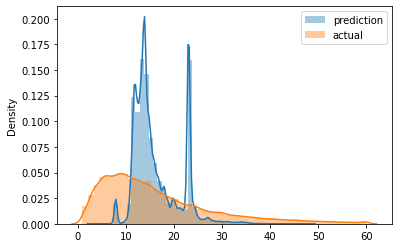

In [16]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Q6. Evaluating the model
Now let's apply this model to the validation dataset (Feb 2021).



In [2]:
#Using the example function for the Validation:
    
def read_dataframe(filename):
    #if filename.endswith('.csv'):
        #df = pd.read_csv(filename)

        #df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        #df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    #Read data
    if filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    #Calculate duration and format it to minutes
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    #Filter outliers out
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    #Impute missing values
    df.PUlocationID.fillna(-1,inplace=True)

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [3]:
df_train = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [4]:
len(df_train), len(df_val)

(1109826, 990113)

In [5]:
df_train['PU_DO'] = df_train['PUlocationID'] + '_' + df_train['DOlocationID']
df_val['PU_DO'] = df_val['PUlocationID'] + '_' + df_val['DOlocationID']

In [6]:
categorical = ['PU_DO']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [7]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

In [9]:
#What's the RMSE on validation?
print('LinearRegression model: The RMSE on the validation is',round(mean_squared_error(y_val, y_pred, squared=False),2),'minutes')


The RMSE on the validation is 10.6 minutes


In [10]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [13]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)


print('Lasso model: The RMSE on the validation is',round(mean_squared_error(y_val, y_pred, squared=False),2),'minutes')


Lasso model: The RMSE on the validation is 11.35 minutes


Submit the results
Submit your results here: https://forms.gle/V8q5rv7QRoZ13Sft6

It's possible that your answers won't match exactly. If it's the case, select the closest one.

Deadline
The deadline for submitting is 23 May 2022, 17:00 CET (Monday). After that, the form will be closed.

Solution
The solution will be put here after the deadline.